Documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the Data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Support Vector Machine

In [10]:
from sklearn.svm import SVR

In [13]:
class ModelEnsembleRegressors():

    def spe(self, y, y_pred): 
        return (y-y_pred)**2
        
    def train(self, df_train):

        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        self.models = {}
        spe_df = pd.DataFrame()
        
        self.to_predict_test = []
        
        for col in df_train.columns:
            
            #print('training model for', col)
            #model = self.regressor(**self.kwargs)
            model = SVR(kernel = 'rbf') #SVR(C=1.0, epsilon=0.2)
            # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
            tr_x = sklearn.preprocessing.scale(df_train.drop([col],axis=1))
            tr_y = sklearn.preprocessing.scale(df_train[col])
        
            model.fit(X=tr_x, y=tr_y)
            
            tr_y_pred = model.predict(X=tr_x)
            
            self.models[col] = model
                                    
            spe_df[col] = self.spe(tr_y, tr_y_pred)
            
            self.to_predict_test.append(col)           
                        
        return np.mean(spe_df, axis=1)
    
    def test(self, df_test):

        spe_df = pd.DataFrame()
        
        for col in self.to_predict_test:
            ts_x = np.array((df_test.drop([col],axis=1)-self.mu_train.drop([col]))/self.std_train.drop([col]))
            ts_y = np.array((df_test[col]-self.mu_train[col])/self.std_train[col])
            ts_y_pred = self.models[col].predict(ts_x)
            spe_df[col] = self.spe(ts_y, ts_y_pred)
                
        return np.mean(spe_df, axis=1)

## Noise filtering

In [9]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Training the Data

In [14]:
models = {'svr': ModelEnsembleRegressors()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

# Testing the Data

svr    49.95
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
svr,99.25,97.875,0.0,0.5,23.375,100.0,93.75,97.125,0.0,5.125,10.5,95.5,89.125,99.75,0.0,3.125,66.625,91.5,0.0,25.875


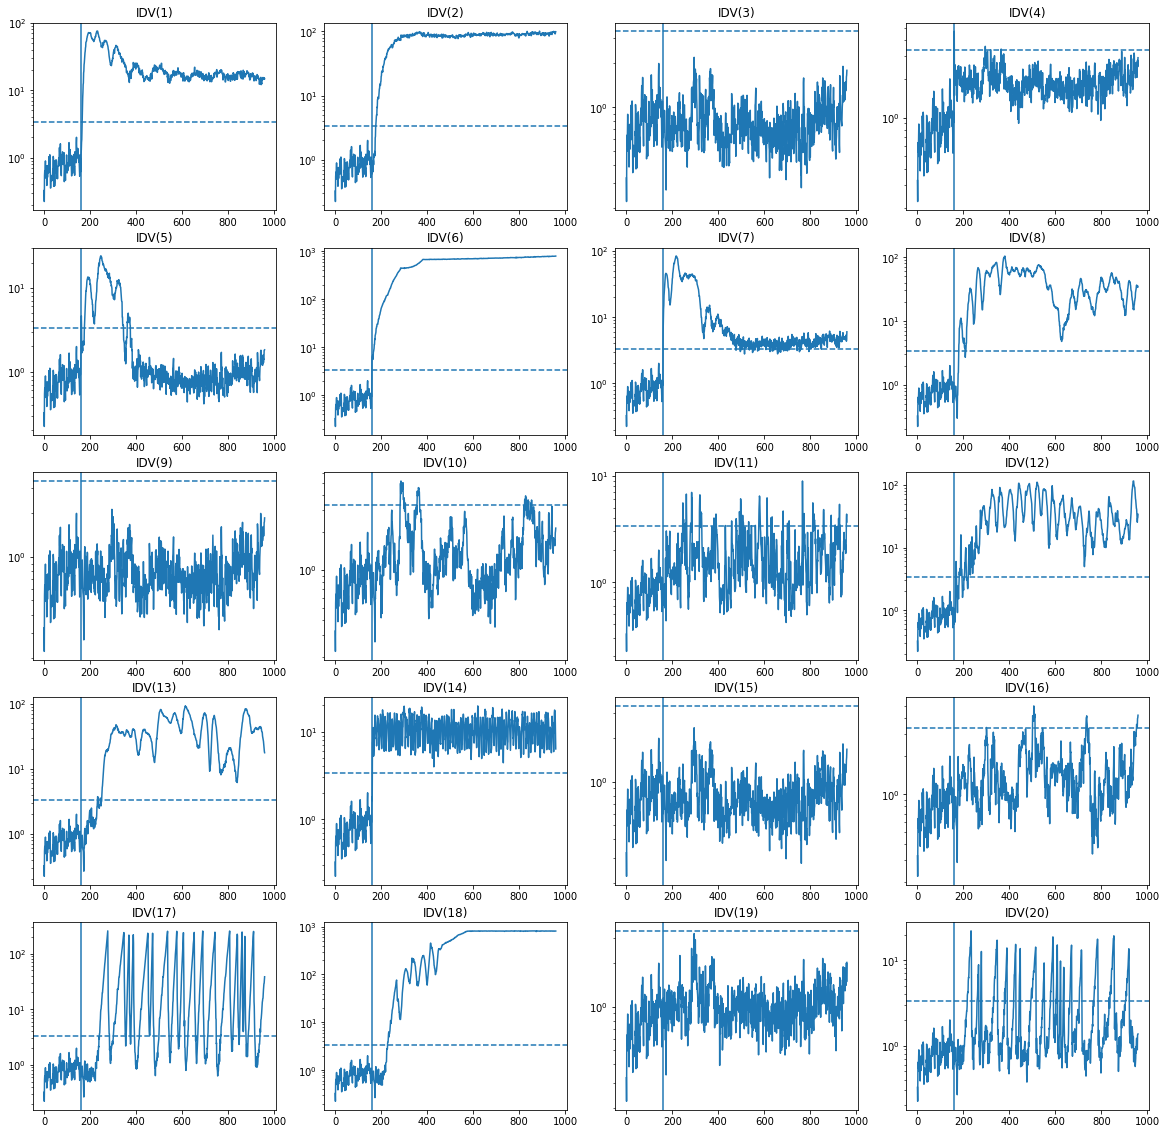

In [15]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

## Filter noise

WS_10     52.85625
WS_50     53.05000
WS_100    58.32500
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,98.875,97.75,0.0,99.375,26.000,99.500,99.625,97.00,0.0,5.375,45.375,96.75,90.625,0.5,0.0,1.625,80.500,91.875,0.0,26.375
WS_50,98.125,96.25,0.0,98.375,35.875,98.625,99.250,94.25,0.0,2.125,41.000,84.50,92.875,0.0,0.0,0.000,89.250,90.500,0.0,40.000
WS_100,98.000,95.50,0.0,98.125,96.750,98.500,99.000,94.00,0.0,0.000,43.375,82.25,90.625,0.0,0.0,0.000,89.375,90.000,0.0,91.000


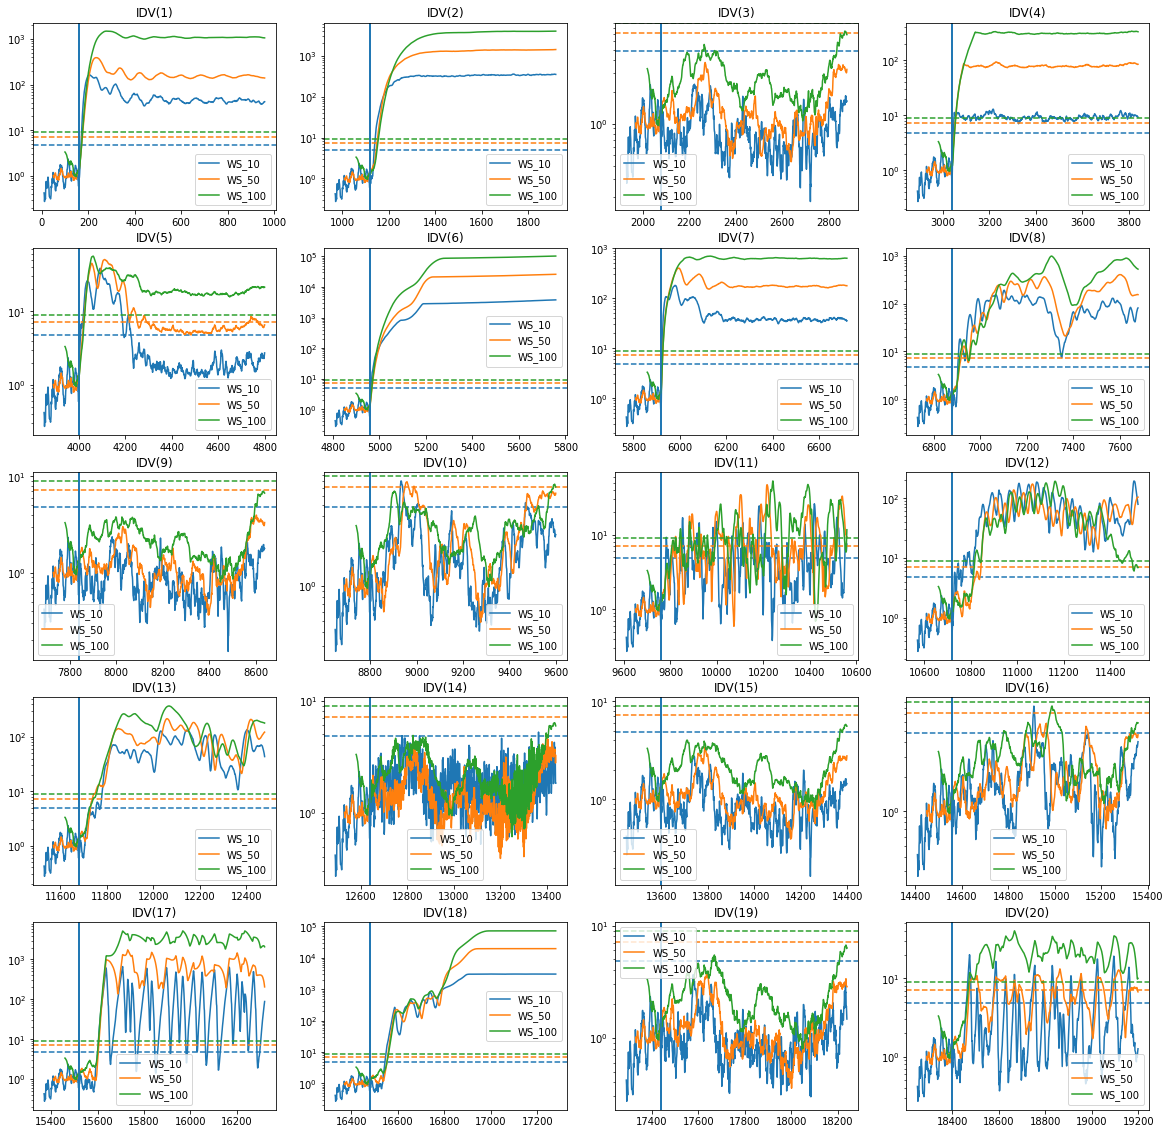

In [16]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelEnsembleRegressors(), 'WS_50': ModelEnsembleRegressors(), 'WS_100': ModelEnsembleRegressors()}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

reference [here](https://www.section.io/engineering-education/support-vector-regression-in-python/)